In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
import pickle

/home/lizx43/anaconda3/envs/gigapath/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
DIS_5X = 2048
DIS_10X = 1024
DIS_20X = 512

In [3]:
def get_neighbors(coords, i, distance=256):
    x, y = coords[i]
    neighbors = []
    for j in range(len(coords)):
        if j != i:
            x_n, y_n = coords[j]
            if abs(x - x_n) <= distance and abs(y - y_n) <= distance:
                neighbors.append(j)
    return neighbors

def create_graph_data(tile_embed_df, coords, y_label, size):
    n_tiles = len(tile_embed_df)
    
    # Create edges based on 8-neighbors
    edges = []
    for i in range(n_tiles):
        neighbors = get_neighbors(coords, i, distance=size)
        for neighbor in neighbors:
            edges.append((i, neighbor))
            # edges.append((neighbor, i))
    
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    x = torch.tensor(np.array(tile_embed_df), dtype=torch.float)
    y = torch.tensor([y_label], dtype=torch.long)
    
    graph_data = Data(x=x, edge_index=edge_index, y=y)
    graph_data.coordinates = torch.tensor(coords, dtype=torch.float)
    return graph_data

In [4]:
def plot_graph(data, coords):
    G = nx.Graph()

    # Add nodes with their coordinates
    for i in range(data.x.shape[0]):
        G.add_node(i, pos=(coords[i][0], coords[i][1]))

    # Add edges
    edges = data.edge_index.t().tolist()
    G.add_edges_from(edges)

    # Get positions for all nodes
    pos = nx.get_node_attributes(G, 'pos')

    # Draw the graph
    plt.figure(figsize=(8, 8))
    nx.draw(G, pos, node_size=20, node_color='blue', with_labels=False)
    plt.show()

In [5]:
embedding_dir = '../patch_embeddings/'
tile_20X_df = pd.read_hdf(embedding_dir+'20Xtile_embeding.h5')
tile_10X_df = pd.read_hdf(embedding_dir+'10Xtile_embeding.h5')
tile_5X_df = pd.read_hdf(embedding_dir+'5Xtile_embeding.h5')
# len(tile_20X_df.ids.unique())

In [6]:
crc20x_tumor_df = pd.read_hdf('20x_crc_embeddings.h5')
crc20x_tumor_true = crc20x_tumor_df[crc20x_tumor_df['is_tumor']=='Yes']
crc20x_tumor_true

,0,1,2,3,4,5,6,7,8,9,...,1535,ids,coord1,coord2,drug_response,data_source,cluster,cluster_number,is_include,is_tumor
0,-0.713385,-1.437152,0.596422,-0.435814,-0.162651,-0.086121,0.248144,0.913296,0.062546,-0.466292,...,0.245853,225441,34160.0,20984.0,0,CRC,44,44,N,Yes
2,-0.317509,-1.817904,0.355642,0.078800,0.014659,1.242235,0.085924,-0.321047,-0.951605,0.442494,...,-0.804359,225441,29768.0,17080.0,0,CRC,21,21,Y,Yes
3,-0.479113,-1.779146,0.205956,-0.071254,-0.132548,0.313982,0.299431,0.673270,0.244911,0.983710,...,-0.088585,225441,29280.0,18056.0,0,CRC,47,47,Y,Yes
6,-0.148007,-0.462119,-0.569577,0.025895,-1.047039,2.003612,0.286287,0.285261,-0.809437,-0.553638,...,-0.396531,225441,16104.0,12200.0,0,CRC,44,44,N,Yes
7,0.608207,-1.837651,-0.307342,0.222618,-1.252492,0.417990,0.224343,-0.968717,-0.325122,-0.051873,...,-0.546590,225441,29768.0,17568.0,0,CRC,47,47,Y,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723811,-0.275309,-0.860183,-0.717020,0.757876,-1.410894,-1.251571,0.265115,0.413469,0.232582,-0.032978,...,-1.089710,225307,118586.0,26840.0,0,CRC,40,40,N,Yes
723816,-0.231275,-0.893301,2.467249,1.247489,-1.049215,0.808213,0.410580,-0.967024,0.997129,-0.270087,...,0.430591,225307,72225.0,59049.0,0,CRC,30,30,N,Yes
723826,-0.627547,-0.116857,0.234761,1.376596,-0.848310,0.407038,0.400979,0.689036,-0.897396,-0.144772,...,-0.298696,225307,105410.0,50265.0,0,CRC,16,16,N,Yes
723828,-0.606073,0.467184,1.375417,0.437164,1.039197,-0.529705,-0.064332,0.131208,1.558076,1.080192,...,0.150385,225307,144451.0,12200.0,0,CRC,35,35,N,Yes


In [6]:
set20X = set(tile_20X_df.ids.unique())
set10X = set(tile_10X_df.ids.unique())
set5X = set(tile_5X_df.ids.unique())

overlap = set20X.intersection(set10X).intersection(set5X)
# Convert the result back to a list (if needed)
sub_id_list = list(overlap)
df = pd.DataFrame(sub_id_list)
df.to_hdf('id_list.h5', key='df', mode='w')

In [14]:
def get_single_slide_info(embeddings_df, id, size):
    tile_df = embeddings_df[embeddings_df['ids']==id]
    slide_label = list(tile_df.drug_response)[0]
    coords = list(zip(tile_df.coord1, tile_df.coord2))
    tile_embed_df = tile_df.iloc[:, :1536]
    graph_data = create_graph_data(tile_embed_df,coords, slide_label, size)
    plot_graph(graph_data, coords)
    return graph_data

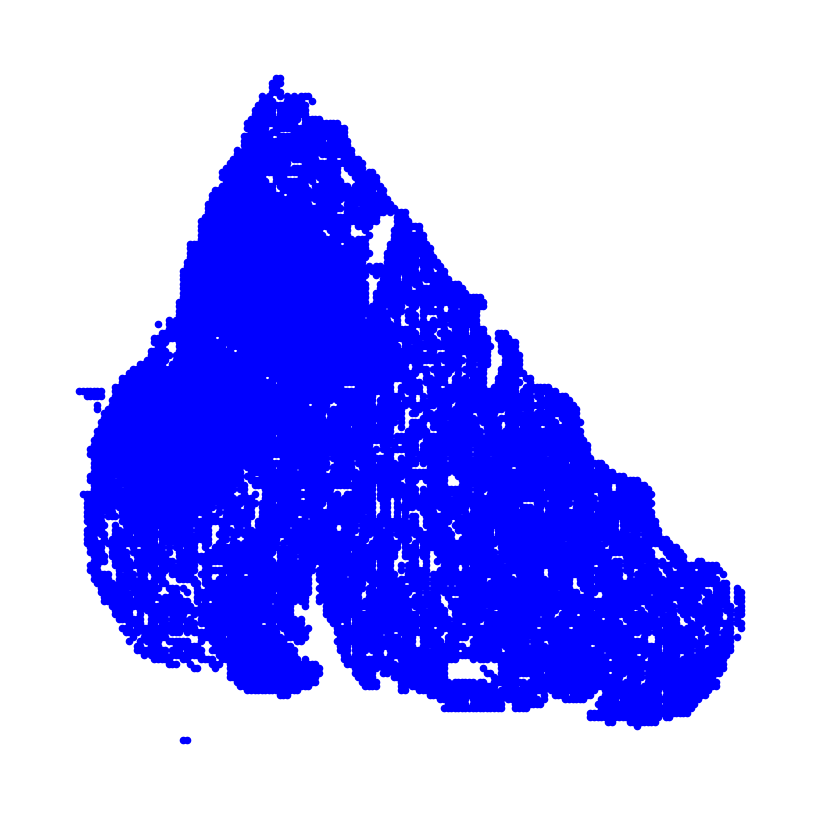

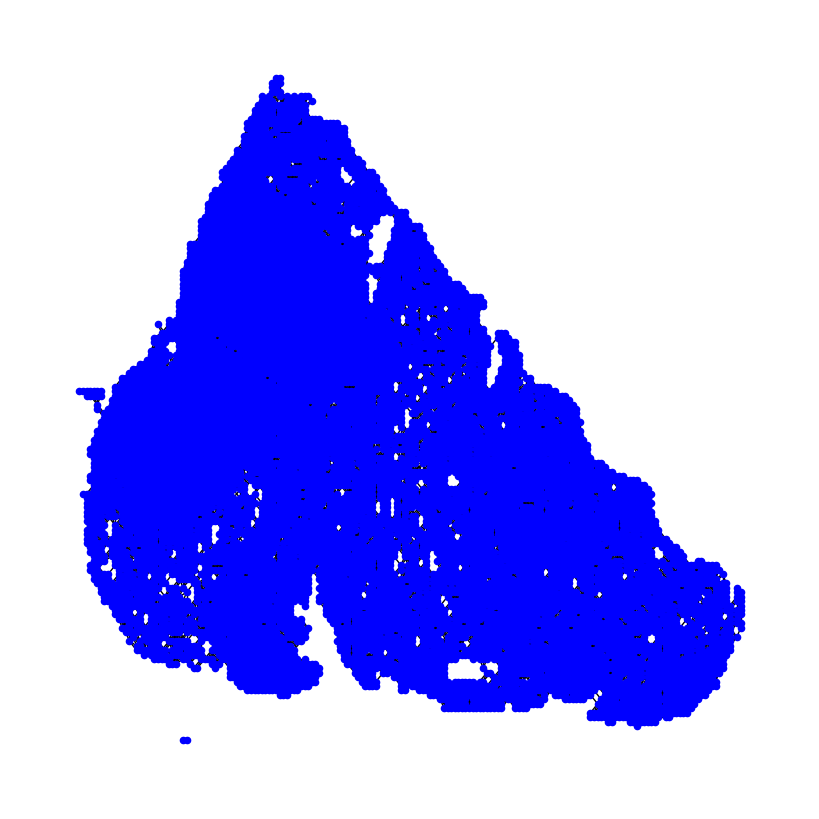

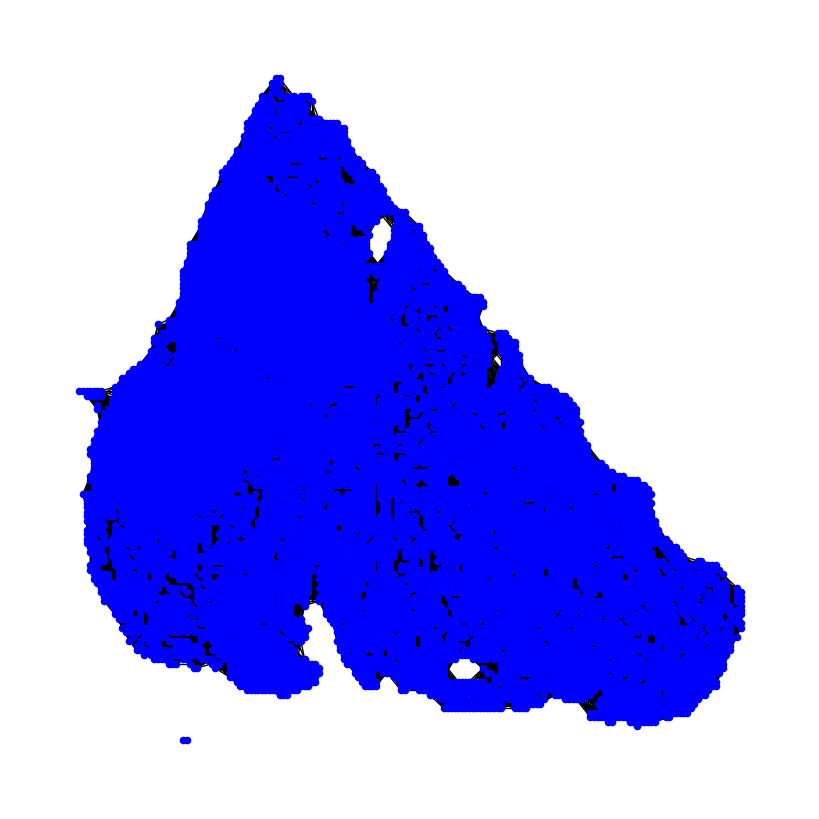

In [15]:
for id in ['133565']:
    graph_data = get_single_slide_info(tile_20X_df, id, 512)
    graph_data = get_single_slide_info(tile_10X_df, id, 1024)
    graph_data = get_single_slide_info(tile_5X_df, id, 2048)

In [9]:
def add_inter_resolution_edges(graphs):
    graph_5x, graph_10x, graph_20x = graphs
    add_high_low_edges(graph_20x, graph_10x, DIS_10X, DIS_20X)
    add_high_low_edges(graph_10x, graph_5x, DIS_5X, DIS_10X)


def add_high_low_edges(high_res_graph, low_res_graph, patch_size_low, patch_size_high):
    for high_idx, high_coord in enumerate(high_res_graph['coordinates']):
                    for low_idx, low_coord in enumerate(low_res_graph['coordinates']):
                        if is_inside_patch(high_coord, low_coord, patch_size_low, patch_size_high):
                            high_res_graph.edge_index = torch.cat(
                                [high_res_graph.edge_index, torch.tensor([[high_idx, low_idx], [low_idx, high_idx]])], dim=1
                            )

def is_inside_patch(coord_high, coord_low, patch_size_low, patch_size_high):
    x_20, y_20 = coord_high
    x_10, y_10 = coord_low

    left_10x = x_10 - patch_size_low / 2
    right_10x = x_10 + patch_size_low / 2
    top_10x = y_10 - patch_size_low / 2
    bottom_10x = y_10 + patch_size_low / 2

    if (left_10x <= x_20 <= right_10x) and (top_10x <= y_20 <= bottom_10x):
        return True
    return False

In [10]:
def combine_three_graphs(graphs):
    graph_5x, graph_10x, graph_20x = graphs
    combined_x = torch.cat([graph_5x.x, graph_10x.x, graph_20x.x], dim=0)
    combined_y = graph_10x.y
    combined_coordinates = torch.cat([graph_5x.coordinates, graph_10x.coordinates, graph_20x.coordinates], dim=0)

    combined_edge_index = torch.cat([
        graph_5x.edge_index, 
        graph_10x.edge_index + len(graph_5x.x), 
        graph_20x.edge_index + len(graph_5x.x) + len(graph_10x.x)
    ], dim=1)
    contains_edges = []

    for low_idx, low_coord in enumerate(graph_5x['coordinates']):
        for high_idx, high_coord in enumerate(graph_10x['coordinates']):
            if is_inside_patch(high_coord, low_coord, DIS_5X, DIS_10X):
                contains_edges.append([low_idx, high_idx + len(graph_5x.coordinates)])

    for low_idx, low_coord in enumerate(graph_10x['coordinates']):
        for high_idx, high_coord in enumerate(graph_20x['coordinates']):
            if is_inside_patch(high_coord, low_coord, DIS_10X, DIS_20X):
                contains_edges.append([low_idx+len(graph_5x.coordinates), high_idx + len(graph_5x.coordinates)+len(graph_10x.coordinates)])

    contains_edges = torch.tensor(contains_edges, dtype=torch.long)
    combined_edge_index = torch.cat([combined_edge_index, contains_edges.t().contiguous()], dim=1)
    combined_graph = Data(x=combined_x, edge_index=combined_edge_index, y=combined_y, coordinates=combined_coordinates)
    return combined_graph


In [11]:
# Contruct the three resolution graph and save it

all_graphs = []
all_labels = []
i = 0
for id in sub_id_list:
    i += 1
    if i % 50 == 0:
        print(i)
    graph_5x = get_single_slide_info(tile_5X_df, id, DIS_5X)
    graph_10x = get_single_slide_info(tile_10X_df, id, DIS_10X)
    graph_20x = get_single_slide_info(tile_20X_df, id, DIS_20X)
    all_graphs.append((graph_5x, graph_10x, graph_20x))
    all_labels.append(int(graph_5x.y[0]))

data_list = []
for (graph_5x, graph_10x, graph_20x), label in zip(all_graphs, all_labels):
    graph_5x.y = torch.tensor([label], dtype=torch.float)
    graph_10x.y = torch.tensor([label], dtype=torch.float)
    graph_20x.y = torch.tensor([label], dtype=torch.float)
    data_list.append((graph_5x, graph_10x, graph_20x))

with open('three_layer_graph.pkl', 'wb') as f:
    pickle.dump(data_list, f)


50
100
150
200


In [12]:
all_graphs = []
all_labels = []
i = 0
for id in list(crc20x_tumor_df.ids.unique()):
    i += 1
    if i % 20 == 0:
        print(i)
    graph_20x = get_single_slide_info(crc20x_tumor_df, id, DIS_20X)
    all_graphs.append(graph_20x)
    all_labels.append(int(graph_20x.y[0]))

data_list = []
for graph_20x, label in zip(all_graphs, all_labels):
    graph_20x.y = torch.tensor([label], dtype=torch.float)
    data_list.append(graph_20x)

with open('crc_20x_tumor_graph.pkl', 'wb') as f:
    pickle.dump(data_list, f)


20
40
60
80
100


In [ ]:
with open('three_layer_graph.pkl', 'rb') as f:
    loaded_object = pickle.load(f)

print(loaded_object)

[(Data(x=[47, 1536], edge_index=[2, 110], y=[1], coordinates=[47, 2]), Data(x=[204, 1536], edge_index=[2, 946], y=[1], coordinates=[204, 2]), Data(x=[820, 1536], edge_index=[2, 4858], y=[1], coordinates=[820, 2])), (Data(x=[455, 1536], edge_index=[2, 3182], y=[1], coordinates=[455, 2]), Data(x=[1784, 1536], edge_index=[2, 12816], y=[1], coordinates=[1784, 2]), Data(x=[7014, 1536], edge_index=[2, 51168], y=[1], coordinates=[7014, 2])), (Data(x=[955, 1536], edge_index=[2, 5792], y=[1], coordinates=[955, 2]), Data(x=[3624, 1536], edge_index=[2, 22388], y=[1], coordinates=[3624, 2]), Data(x=[14151, 1536], edge_index=[2, 91390], y=[1], coordinates=[14151, 2])), (Data(x=[86, 1536], edge_index=[2, 492], y=[1], coordinates=[86, 2]), Data(x=[345, 1536], edge_index=[2, 2202], y=[1], coordinates=[345, 2]), Data(x=[1350, 1536], edge_index=[2, 9216], y=[1], coordinates=[1350, 2])), (Data(x=[6, 1536], edge_index=[2, 4], y=[1], coordinates=[6, 2]), Data(x=[78, 1536], edge_index=[2, 146], y=[1], coord

In [ ]:
from GNN import GCN
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

train_graphs, test_graphs = train_test_split(loaded_object, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(in_channels=1536, out_channels=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
train_loader = DataLoader(train_graphs, batch_size=1, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=1, shuffle=False)

def train():
    model.train()
    for data in train_loader:
        data = data[2].to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.cross_entropy(out, data.y.long())
        loss.backward()
        optimizer.step()

for epoch in range(100):  
    if epoch % 10 == 0:
        print(epoch)# Adjust the number of epochs as needed
    train()

/home/lizx43/anaconda3/envs/gigapath/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


0
10
20
30
40
50
60
70
80
90


In [ ]:
def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        data = data[2].to(device)
        out = model(data)
        pred = out.argmax(dim=1)
        correct += int((pred == data.y).sum())
    return correct / len(loader.dataset)

train_accuracy = test(train_loader)
test_accuracy = test(test_loader)

print('Train Accuracy: {:.4f}'.format(train_accuracy))
print('Test Accuracy: {:.4f}'.format(test_accuracy))

Train Accuracy: 1.0000
Test Accuracy: 0.5476


In [ ]:
def evaluate(loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data[2].to(device)
            out = model(data)
            preds = out.argmax(dim=1).cpu().numpy()
            labels = data.y.view(-1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)
    return all_labels, all_preds
test_labels, test_preds = evaluate(test_loader)
report = classification_report(test_labels, test_preds, target_names=['non-responder', 'responder'])
print(report)

               precision    recall  f1-score   support

non-responder       0.73      0.61      0.67        31
    responder       0.25      0.36      0.30        11

     accuracy                           0.55        42
    macro avg       0.49      0.49      0.48        42
 weighted avg       0.60      0.55      0.57        42



In [ ]:
train_labels, train_preds = evaluate(train_loader)
report = classification_report(train_labels, train_preds, target_names=['non-responder', 'responder'])
print(report)

               precision    recall  f1-score   support

non-responder       1.00      1.00      1.00       116
    responder       1.00      1.00      1.00        51

     accuracy                           1.00       167
    macro avg       1.00      1.00      1.00       167
 weighted avg       1.00      1.00      1.00       167

